In [1]:
import os
from IPython import get_ipython
import numpy as np
import matplotlib.pyplot as plt
from ple.games.flappybird import FlappyBird
from ple import PLE

ipy = get_ipython()
if ipy is not None:
    ipy.run_line_magic("matplotlib", "inline")
os.environ["SDL_VIDEODRIVER"] = "dummy"  # this line disable pop-out window
game = FlappyBird()
env = PLE(game, fps=30, display_screen=False)  # environment interface to game
env.reset_game()

pygame 2.6.1 (SDL 2.28.4, Python 3.10.15)
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_sn

In [2]:
# return a dictionary whose key is action description and value is action index
print(game.actions)
# return a list of action index (include None)
print(env.getActionSet())

{'up': 119}
[119, None]


In [3]:
# a dictionary describe state
"""
player y position.
players velocity.
next pipe distance to player
next pipe top y position
next pipe bottom y position
next next pipe distance to player
next next pipe top y position
next next pipe bottom y position
"""
game.getGameState()

{'player_y': 256,
 'player_vel': 0,
 'next_pipe_dist_to_player': 309.0,
 'next_pipe_top_y': np.int64(144),
 'next_pipe_bottom_y': np.int64(244),
 'next_next_pipe_dist_to_player': 453.0,
 'next_next_pipe_top_y': np.int64(160),
 'next_next_pipe_bottom_y': np.int64(260)}

In [4]:
import math
import copy
from collections import defaultdict

MIN_EXPLORING_RATE = 0.01
MIN_LEARNING_RATE = 0.5


class Agent:
    def __init__(
        self, bucket_range_per_feature, num_action, t=0, discount_factor=0.99
    ):
        self.update_parameters(t)  # init explore rate and learning rate
        self.q_table = defaultdict(lambda: np.zeros(num_action))
        self.discount_factor = discount_factor
        self.num_action = num_action

        # how to discretize each feature in a state
        # the higher each value, less time to train but with worser performance
        # e.g. if range = 2, feature with value 1 is equal to feature with value 0 bacause int(1/2) = int(0/2)
        self.bucket_range_per_feature = bucket_range_per_feature

    def select_action(self, state):
        # epsilon-greedy
        state_idx = self.get_state_idx(state)
        if np.random.rand() < self.exploring_rate:
            action = np.random.choice(num_action)  # Select a random action
        else:
            action = np.argmax(
                self.q_table[state_idx]
            )  # Select the action with the highest q
        return action

    def update_policy(self, state, action, reward, state_prime):
        state_idx = self.get_state_idx(state)
        state_prime_idx = self.get_state_idx(state_prime)
        # Update Q_value using Q-learning update rule
        best_q = np.max(self.q_table[state_prime_idx])
        self.q_table[state_idx][action] += self.learning_rate * (
            reward
            + self.discount_factor * best_q
            - self.q_table[state_idx][action]
        )

    def get_state_idx(self, state):
        # instead of using absolute position of pipe, use relative position
        state = copy.deepcopy(state)
        state["next_next_pipe_bottom_y"] -= state["player_y"]
        state["next_next_pipe_top_y"] -= state["player_y"]
        state["next_pipe_bottom_y"] -= state["player_y"]
        state["next_pipe_top_y"] -= state["player_y"]

        # sort to make list converted from dict ordered in alphabet order
        state_key = [k for k, v in sorted(state.items())]

        # do bucketing to decrease state space to speed up training
        state_idx = []
        for key in state_key:
            state_idx.append(
                int(state[key] / self.bucket_range_per_feature[key])
            )
        return tuple(state_idx)

    def update_parameters(self, episode):
        self.exploring_rate = max(
            MIN_EXPLORING_RATE, min(0.5, 0.99 ** ((episode) / 30))
        )
        self.learning_rate = max(
            MIN_LEARNING_RATE, min(0.5, 0.99 ** ((episode) / 30))
        )

    def shutdown_explore(self):
        # make action selection greedy
        self.exploring_rate = 0

In [5]:
class SarsaAgent:
    def __init__(
        self, bucket_range_per_feature, num_action, t=0, discount_factor=0.99
    ):
        self.update_parameters(t)  # init explore rate and learning rate
        self.q_table = defaultdict(lambda: np.zeros(num_action))
        self.discount_factor = discount_factor
        self.num_action = num_action

        # how to discretize each feature in a state
        # the higher each value, less time to train but with worser performance
        # e.g. if range = 2, feature with value 1 is equal to feature with value 0 bacause int(1/2) = int(0/2)
        self.bucket_range_per_feature = bucket_range_per_feature

    def select_action(self, state):
        # epsilon-greedy
        state_idx = self.get_state_idx(state)
        if np.random.rand() < self.exploring_rate:
            action = np.random.choice(num_action)  # Select a random action
        else:
            action = np.argmax(
                self.q_table[state_idx]
            )  # Select the action with the highest q
        return action

    def update_policy(self, state, action, reward, state_prime, action_prime):
        state_idx = self.get_state_idx(state)
        state_prime_idx = self.get_state_idx(state_prime)
        # Update Q_value using SARSA update rule
        q_prime = self.q_table[state_prime_idx][action_prime]
        self.q_table[state_idx][action] += self.learning_rate * (
            reward
            + self.discount_factor * q_prime
            - self.q_table[state_idx][action]
        )

    def get_state_idx(self, state):
        # instead of using absolute position of pipe, use relative position
        state = copy.deepcopy(state)
        state["next_next_pipe_bottom_y"] -= state["player_y"]
        state["next_next_pipe_top_y"] -= state["player_y"]
        state["next_pipe_bottom_y"] -= state["player_y"]
        state["next_pipe_top_y"] -= state["player_y"]

        # sort to make list converted from dict ordered in alphabet order
        state_key = [k for k, v in sorted(state.items())]

        # do bucketing to decrease state space to speed up training
        state_idx = []
        for key in state_key:
            state_idx.append(
                int(state[key] / self.bucket_range_per_feature[key])
            )
        return tuple(state_idx)

    def update_parameters(self, episode):
        self.exploring_rate = max(
            MIN_EXPLORING_RATE, min(0.5, 0.99 ** ((episode) / 30))
        )
        self.learning_rate = max(
            MIN_LEARNING_RATE, min(0.5, 0.99 ** ((episode) / 30))
        )

    def shutdown_explore(self):
        # make action selection greedy
        self.exploring_rate = 0

In [6]:
num_action = len(env.getActionSet())
bucket_range_per_feature = {
    "next_next_pipe_bottom_y": 40,
    "next_next_pipe_dist_to_player": 512,
    "next_next_pipe_top_y": 40,
    "next_pipe_bottom_y": 20,
    "next_pipe_dist_to_player": 20,
    "next_pipe_top_y": 20,
    "player_vel": 4,
    "player_y": 16,
}
# init agent
# agent = Agent(bucket_range_per_feature, num_action)
agent = SarsaAgent(bucket_range_per_feature, num_action)

In [7]:
import moviepy.editor as mpy


def make_anim(images, fps=60, true_image=False):
    duration = len(images) / fps

    def make_frame(t):
        try:
            x = images[int(len(images) / duration * t)]
        except:
            x = images[-1]

        if true_image:
            return x.astype(np.uint8)
        else:
            return ((x + 1) / 2 * 255).astype(np.uint8)

    clip = mpy.VideoClip(make_frame, duration=duration)
    clip.fps = fps
    return clip

ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No such file or directory
ALSA lib confmisc.c:1334:(snd_func_refer) error evaluating name
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_refer returned error: No such file or directory
ALSA lib conf.c:5701:(snd_config_expand) Evaluate error: No such file or directory
ALSA lib pcm.c:2664:(snd_pcm_open_noupdate) Unknown PCM default
ALSA lib confmisc.c:855:(parse_card) cannot find card '0'
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_card_inum returned error: No such file or directory
ALSA lib confmisc.c:422:(snd_func_concat) error evaluating strings
ALSA lib conf.c:5178:(_snd_config_evaluate) function snd_func_concat returned error: No su

In [ ]:
from IPython.display import display

reward_per_epoch = []
lifetime_per_epoch = []
exploring_rates = []
learning_rates = []
print_every_episode = 500
show_gif_every_episode = 5000
NUM_EPISODE = 40000
for episode in range(0, NUM_EPISODE):

    # Reset the environment
    env.reset_game()

    # record frame
    frames = [env.getScreenRGB()]

    # for every 500 episodes, shutdown exploration to see performance of greedy action
    if episode % print_every_episode == 0:
        agent.shutdown_explore()

    # the initial state
    state = game.getGameState()
    # cumulate reward for this episode
    cum_reward = 0
    t = 0

    # select an action
    if isinstance(agent, SarsaAgent):
        action = agent.select_action(state)

    while not env.game_over():

        # select an action
        if isinstance(agent, Agent):
            action = agent.select_action(state)

        # execute the action and get reward
        # reward = +1 when pass a pipe, -5 when die
        reward = env.act(env.getActionSet()[action])

        frames.append(env.getScreenRGB())

        # cumulate reward
        cum_reward += reward

        # observe the result
        state_prime = game.getGameState()  # get next state

        # select an action
        if isinstance(agent, SarsaAgent):
            action_prime = agent.select_action(state_prime)

        # update agent
        if isinstance(agent, Agent):
            agent.update_policy(state, action, reward, state_prime)
        elif isinstance(agent, SarsaAgent):
            agent.update_policy(
                state, action, reward, state_prime, action_prime
            )

        # Setting up for the next iteration
        state = state_prime
        if isinstance(agent, SarsaAgent):
            action = action_prime
        t += 1

    # update exploring_rate and learning_rate
    agent.update_parameters(episode)

    if episode % print_every_episode == 0:
        print(
            "Episode {} finished after {} time steps, cumulated reward: {}, exploring rate: {}, learning rate: {}".format(
                episode,
                t,
                cum_reward,
                agent.exploring_rate,
                agent.learning_rate,
            )
        )
        reward_per_epoch.append(cum_reward)
        exploring_rates.append(agent.exploring_rate)
        learning_rates.append(agent.learning_rate)
        lifetime_per_epoch.append(t)

    # for every 5000 episode, record an animation
    if episode % show_gif_every_episode == 0:
        print("Got {} frames in episode {}".format(len(frames), episode))
        clip = make_anim(frames, fps=60, true_image=True).rotate(-90)
        display(clip.ipython_display(fps=60, autoplay=1, loop=1))

Episode 0 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Got 63 frames in episode 0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 1000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 1500 finished after 58 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 2000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.5, learning rate: 0.5
Episode 2500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.43277903725889943, learning rate: 0.5
Episode 3000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.3660323412732292, learning rate: 0.5
Episode 3500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.30957986252419073, learning rate: 0.5
Episode 4000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.26183394327157605, learning rate: 0.5
Episode 4500 finished after 62 time steps, cumulated reward: -5.0, exploring rate:

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 5500 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.15841112426184903, learning rate: 0.5
Episode 6000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.13397967485796172, learning rate: 0.5
Episode 6500 finished after 72 time steps, cumulated reward: -4.0, exploring rate: 0.11331624189077398, learning rate: 0.5
Episode 7000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.09583969128049684, learning rate: 0.5
Episode 7500 finished after 73 time steps, cumulated reward: -4.0, exploring rate: 0.08105851616218128, learning rate: 0.5
Episode 8000 finished after 77 time steps, cumulated reward: -4.0, exploring rate: 0.0685570138491429, learning rate: 0.5
Episode 8500 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.05798359469728905, learning rate: 0.5
Episode 9000 finished after 72 time steps, cumulated reward: -4.0, exploring rate: 0.04904089407128572, learning rate: 0.5
Episode 9500 fini

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 10500 finished after 68 time steps, cumulated reward: -4.0, exploring rate: 0.029670038450977102, learning rate: 0.5
Episode 11000 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.02509408428990297, learning rate: 0.5
Episode 11500 finished after 76 time steps, cumulated reward: -4.0, exploring rate: 0.021223870922486707, learning rate: 0.5
Episode 12000 finished after 72 time steps, cumulated reward: -4.0, exploring rate: 0.017950553275045137, learning rate: 0.5
Episode 12500 finished after 175 time steps, cumulated reward: -2.0, exploring rate: 0.015182073244652034, learning rate: 0.5
Episode 13000 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.012840570676248398, learning rate: 0.5
Episode 13500 finished after 135 time steps, cumulated reward: -3.0, exploring rate: 0.010860193639877882, learning rate: 0.5
Episode 14000 finished after 174 time steps, cumulated reward: -2.0, exploring rate: 0.01, learning rate: 0.5
Episode 14500

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 15500 finished after 175 time steps, cumulated reward: -2.0, exploring rate: 0.01, learning rate: 0.5
Episode 16000 finished after 473 time steps, cumulated reward: 6.0, exploring rate: 0.01, learning rate: 0.5
Episode 16500 finished after 61 time steps, cumulated reward: -5.0, exploring rate: 0.01, learning rate: 0.5
Episode 17000 finished after 98 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 17500 finished after 247 time steps, cumulated reward: 0.0, exploring rate: 0.01, learning rate: 0.5
Episode 18000 finished after 247 time steps, cumulated reward: 0.0, exploring rate: 0.01, learning rate: 0.5
Episode 18500 finished after 165 time steps, cumulated reward: -2.0, exploring rate: 0.01, learning rate: 0.5
Episode 19000 finished after 436 time steps, cumulated reward: 5.0, exploring rate: 0.01, learning rate: 0.5
Episode 19500 finished after 664 time steps, cumulated reward: 11.0, exploring rate: 0.01, learning rate: 0.5
Episode 20000 fi

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 20500 finished after 175 time steps, cumulated reward: -2.0, exploring rate: 0.01, learning rate: 0.5
Episode 21000 finished after 473 time steps, cumulated reward: 6.0, exploring rate: 0.01, learning rate: 0.5
Episode 21500 finished after 95 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 22000 finished after 62 time steps, cumulated reward: -5.0, exploring rate: 0.01, learning rate: 0.5
Episode 22500 finished after 263 time steps, cumulated reward: 1.0, exploring rate: 0.01, learning rate: 0.5
Episode 23000 finished after 550 time steps, cumulated reward: 8.0, exploring rate: 0.01, learning rate: 0.5
Episode 23500 finished after 473 time steps, cumulated reward: 6.0, exploring rate: 0.01, learning rate: 0.5
Episode 24000 finished after 1192 time steps, cumulated reward: 25.0, exploring rate: 0.01, learning rate: 0.5
Episode 24500 finished after 1680 time steps, cumulated reward: 38.0, exploring rate: 0.01, learning rate: 0.5
Episode 25000 

Moviepy - Done !
Moviepy - video ready __temp__.mp4


Episode 25500 finished after 93 time steps, cumulated reward: -4.0, exploring rate: 0.01, learning rate: 0.5
Episode 26000 finished after 437 time steps, cumulated reward: 5.0, exploring rate: 0.01, learning rate: 0.5
Episode 26500 finished after 134 time steps, cumulated reward: -3.0, exploring rate: 0.01, learning rate: 0.5
Episode 27000 finished after 550 time steps, cumulated reward: 8.0, exploring rate: 0.01, learning rate: 0.5
Episode 27500 finished after 627 time steps, cumulated reward: 10.0, exploring rate: 0.01, learning rate: 0.5
Episode 28000 finished after 107 time steps, cumulated reward: -3.0, exploring rate: 0.01, learning rate: 0.5
Episode 28500 finished after 301 time steps, cumulated reward: 2.0, exploring rate: 0.01, learning rate: 0.5


KeyboardInterrupt: 

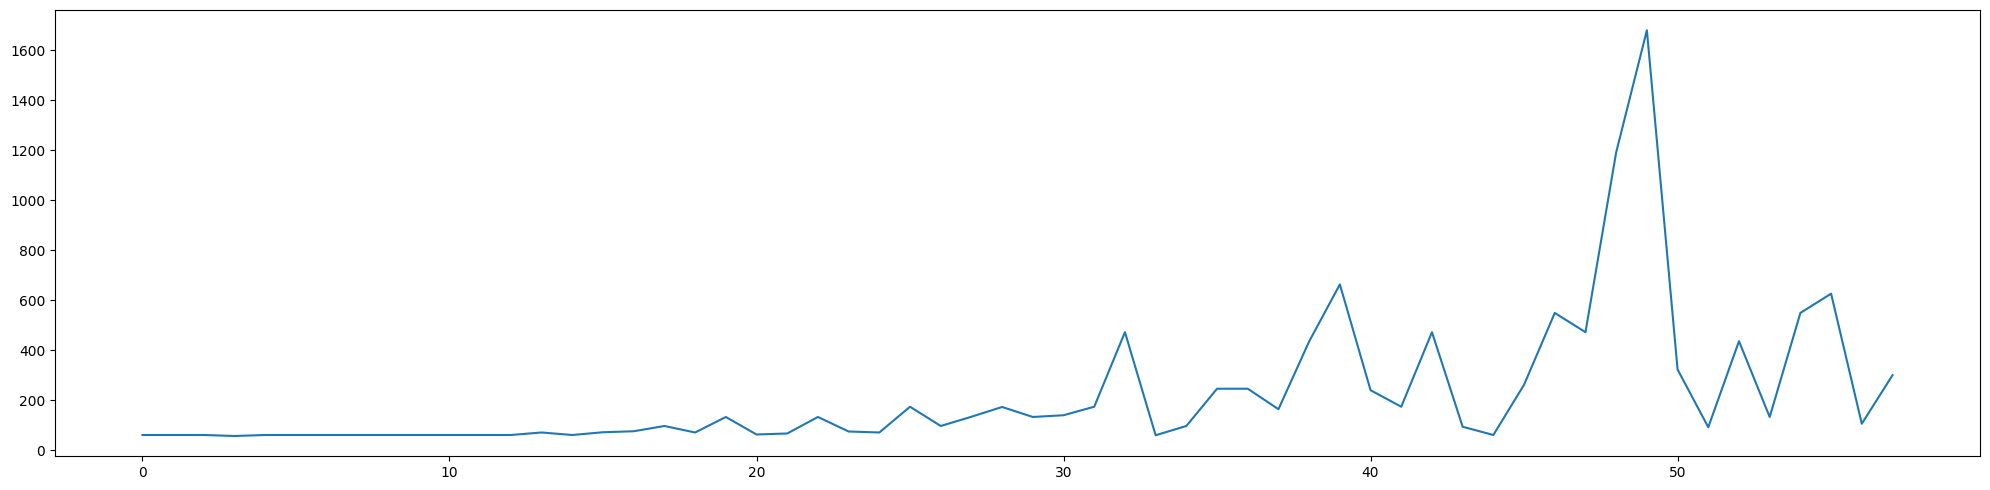

In [9]:
# plot life time against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(lifetime_per_epoch)), lifetime_per_epoch)
fig.tight_layout()
plt.show()

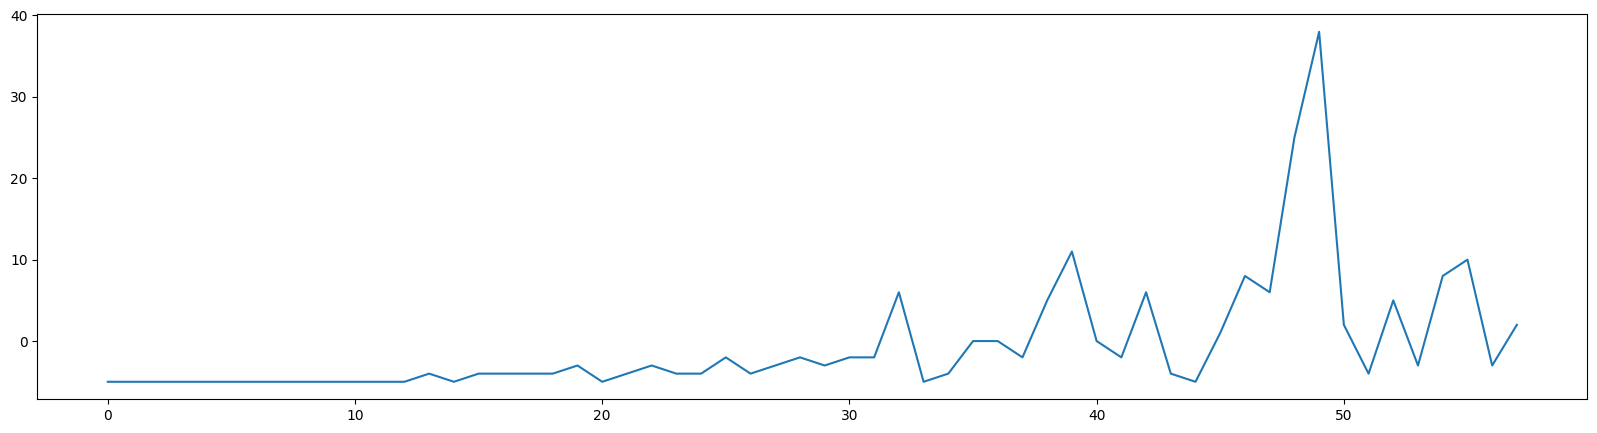

In [10]:
# plot reward against training episodes
fig, ax1 = plt.subplots(figsize=(20, 5))
plt.plot(range(len(reward_per_epoch)), reward_per_epoch)
plt.show()

# Report

## Lifetime per epoch

Q-Learning
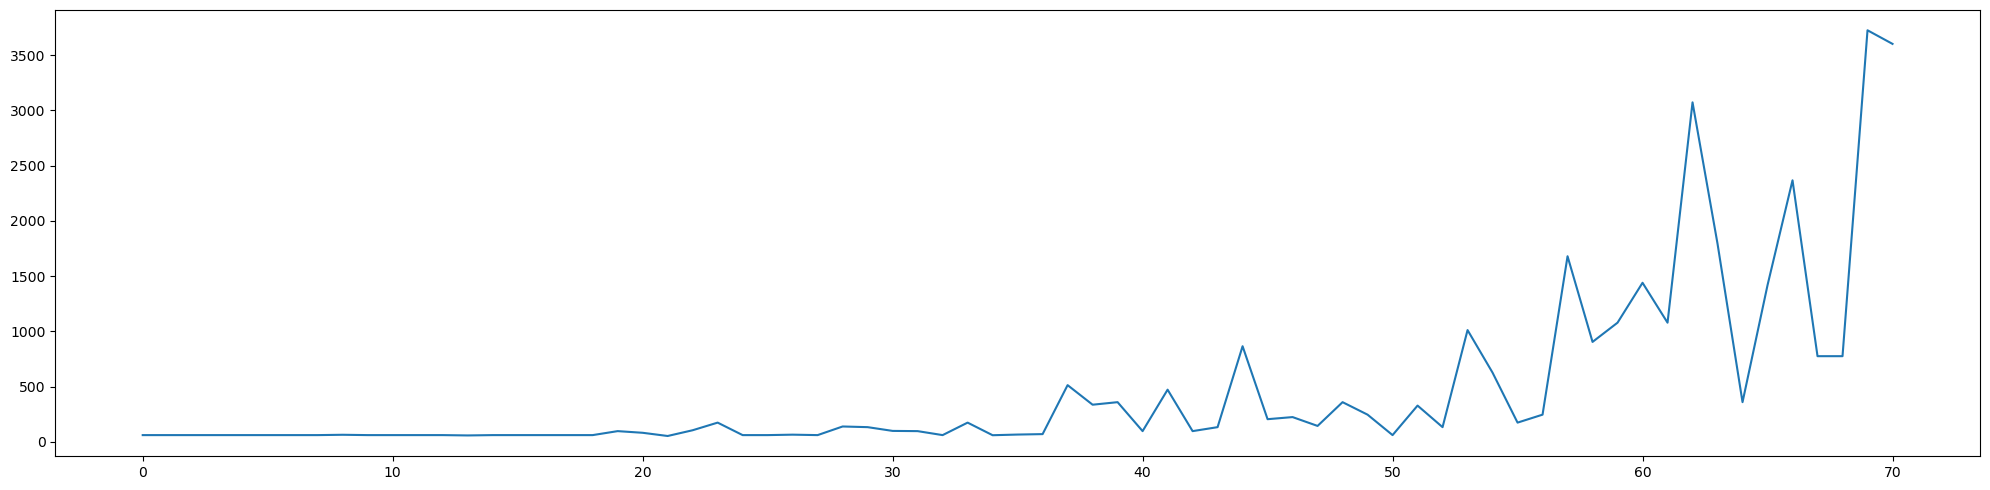

SARSA
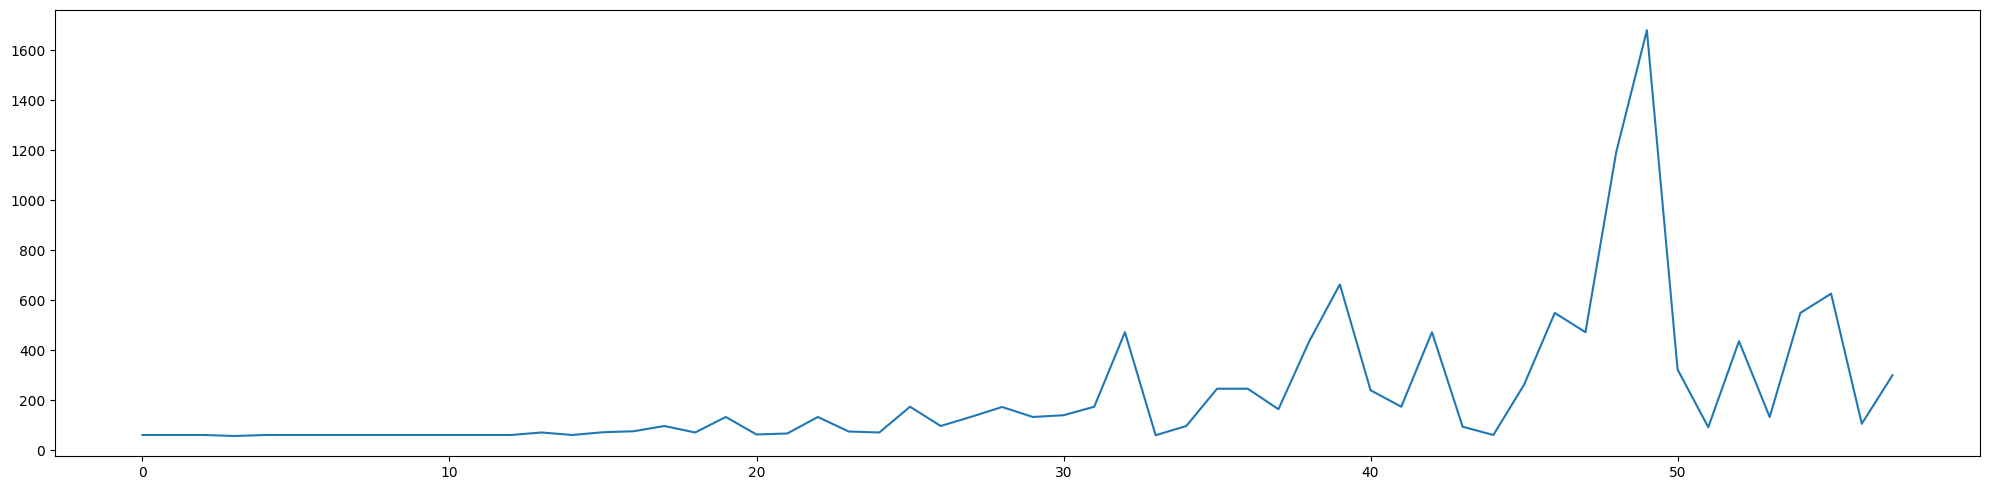

## Reward per epoch

Q-Learning
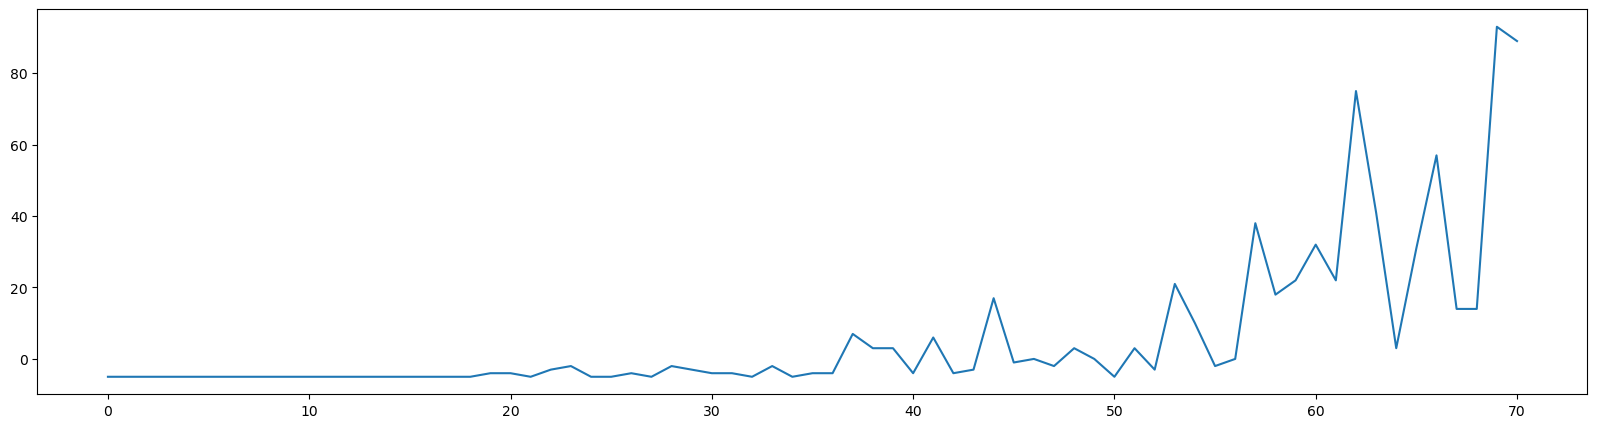

SARSA
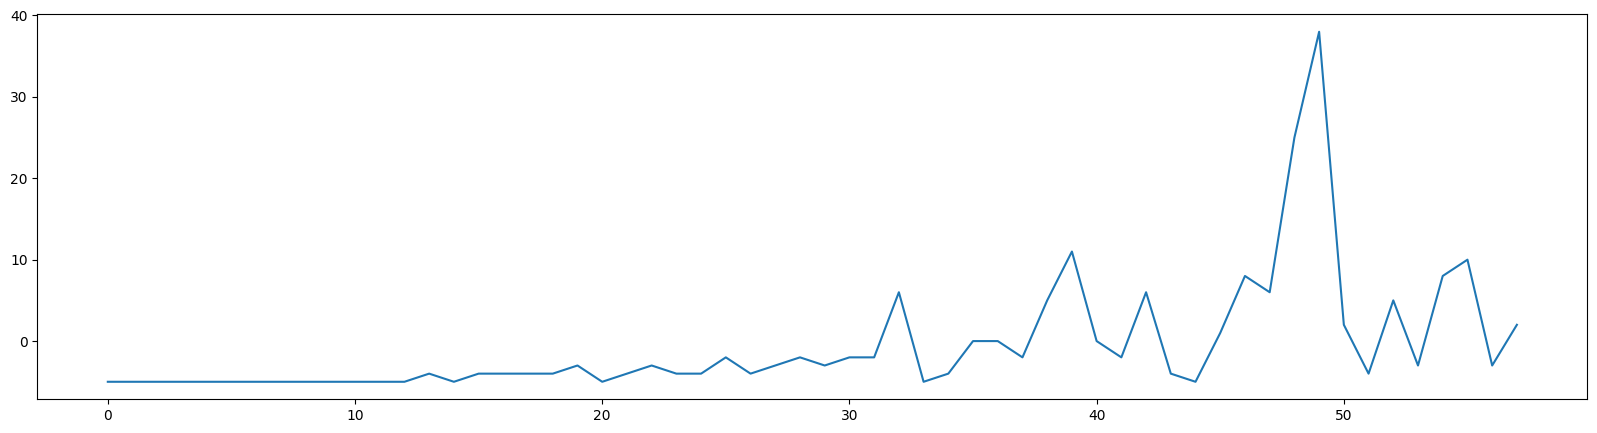

## Explanation

For implemention, I simply follow the algorithm, copied and modified from the Q-learning Agent and created the SARSA agent.
The main difference is that SARSA is on-policy learning, so it will update the Q-value based on the action it actually takes, while Q-learning is off-policy learning, so it will update the Q-value based on the action that gives the maximum Q-value.

I have implemented in a switchable way, so we can easily see the difference between the two algorithms.

Next we can see that training either SARSA or Q-learning really takes a lot of time.

Then we can see SARSA is less stable than Q-learning, as the lifetime and reward fluctuates a lot more, while ending in a worse result at the same episode.
